In [293]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import re
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, roc_auc_score, make_scorer

In [102]:
dt_model = pd.read_excel("data_test.xlsx",sheetname='Data',header=None)
col_x = ['x_a','x_b','x_c','x_d','x_e','x_f','x_g','x_h','x_i','x_j']
col_y = ['y_k','y_l','y_m','y_n']
dt_model.columns = col_x + col_y
print (dt_model.shape)
dt_model.head()

(4900, 14)


,x_a,x_b,x_c,x_d,x_e,x_f,x_g,x_h,x_i,x_j,y_k,y_l,y_m,y_n
0,0.730968,0.240536,0.637417,0.550437,0.597545,0.333218,0.385189,0.984842,0.879183,Николаев,-0.390167,0.196191,6.086174,0.0
1,0.146602,0.023238,0.546740,0.964487,0.104491,0.625146,0.410796,0.776312,0.990723,Евтушенко,-0.643389,0.990202,0.729146,0.0
2,0.746241,0.733152,0.817297,0.838890,0.526699,0.899335,0.133940,0.083062,0.978574,Петров,0.441104,0.636456,-0.080105,1.0
3,0.462958,0.004486,0.071498,0.348420,0.338770,0.859357,0.971547,0.865746,0.612581,Петров,-0.731880,-0.440418,-0.045461,0.0
4,0.217570,0.854487,0.009673,0.692293,0.771313,0.712687,0.211235,0.783092,0.945333,Иванов,-0.315452,-0.898631,-4.780669,0.0


#### Visual analysis

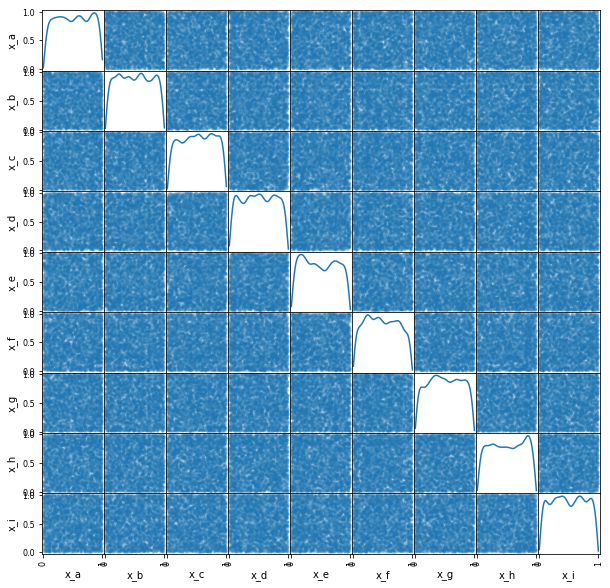

In [52]:
scatter_matrix(dt_model[col_x],alpha=0.2,figsize=(10,10),diagonal = 'kde')
plt.show()

Из графика делаем вывод, что зависимости между переменными нету, и что все данные смоделированы функцией, генерирующей случайные числа

In [61]:
dt_model.groupby('x_j').count()['x_a']

x_j
Евтушенко     641
Иванов        602
Козлов        627
Николаев      622
Петров       1185
Сидорин       636
Сидоров       587
Name: x_a, dtype: int64

В данных чаще всего встречается фамилия 'Петров'. Все остальные фамилии встречаются более или менее одинаковое число раз. Всего в данных 7 фамилий. Наблюдений в каждой группе достаточно, чтобы сделать one hot encoding.

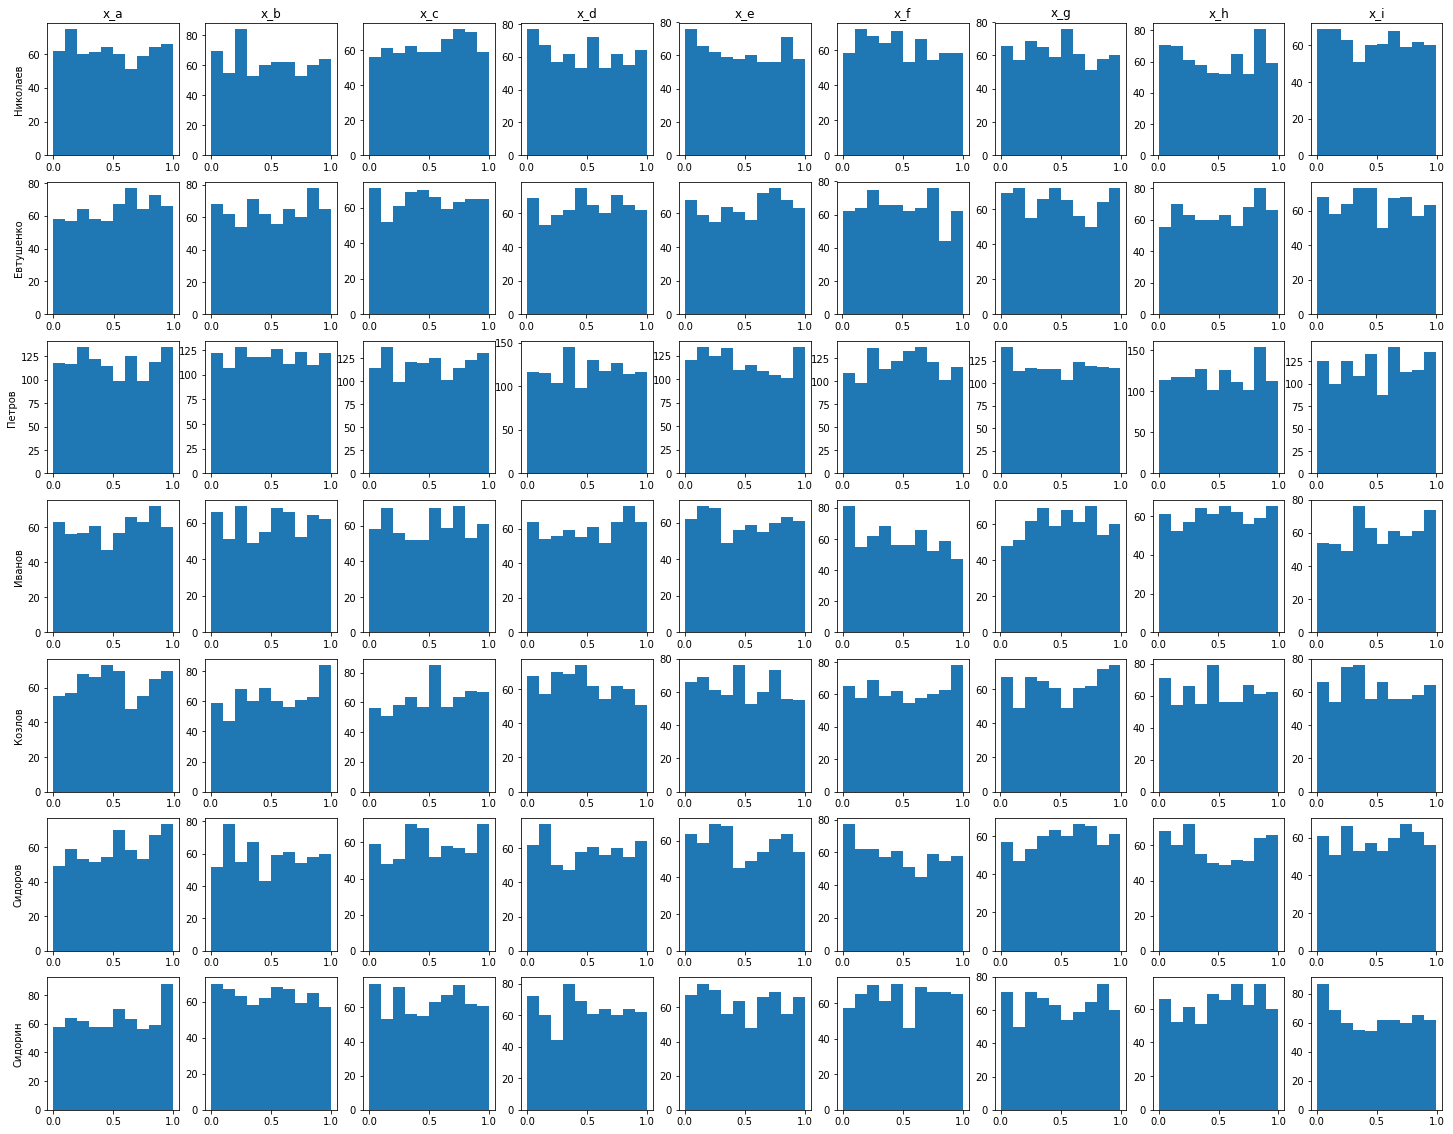

In [100]:
fig, axs = plt.subplots(7, 9,figsize=(25, 20))
fam_arr = dt_model['x_j'].unique()

## name rows
for i in range(len(axs)):
    axs[i,0].set_ylabel(fam_arr[i])
    
## name columns
for i in range(len(col_x)-1):
    axs[0,i].set_title(col_x[i])

## plot data
for i in range(len(axs)):
    fam_val = fam_arr[i]
    dt_plot = dt_model.query('x_j=="'+fam_val+'"').copy(deep=True)
    for j in  range(len(col_x)-1):
        axs[i,j].hist(dt_plot[col_x[j]])
        
        
plt.show()

Относительно фамилий данные тоже распределены случайно

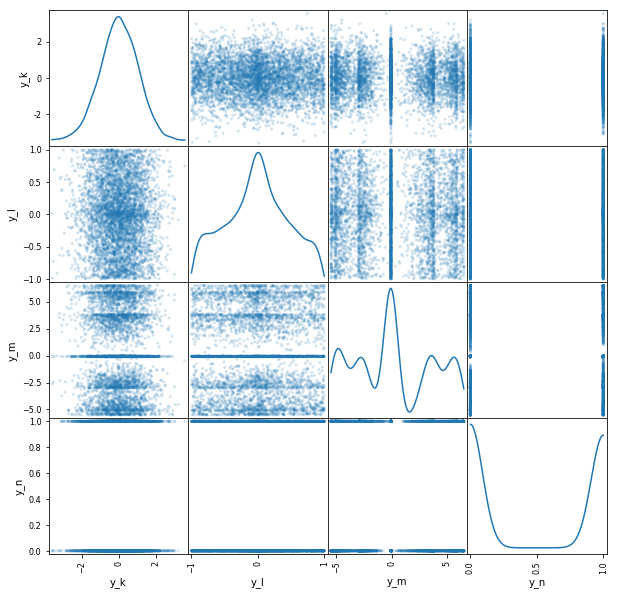

In [103]:
scatter_matrix(dt_model[col_y],alpha=0.2,figsize=(10,10),diagonal = 'kde')
plt.show()

Из графика видно, что переменные y_k и y_l имеют распределения, схожие с нормальными с явными пиками в нуле. Для переменной y_m достаточно чётко прослеживаются четыре значения, которые встречаются чаще всего. y_n смоделирована случайной выборкой из нулей и единиц. 

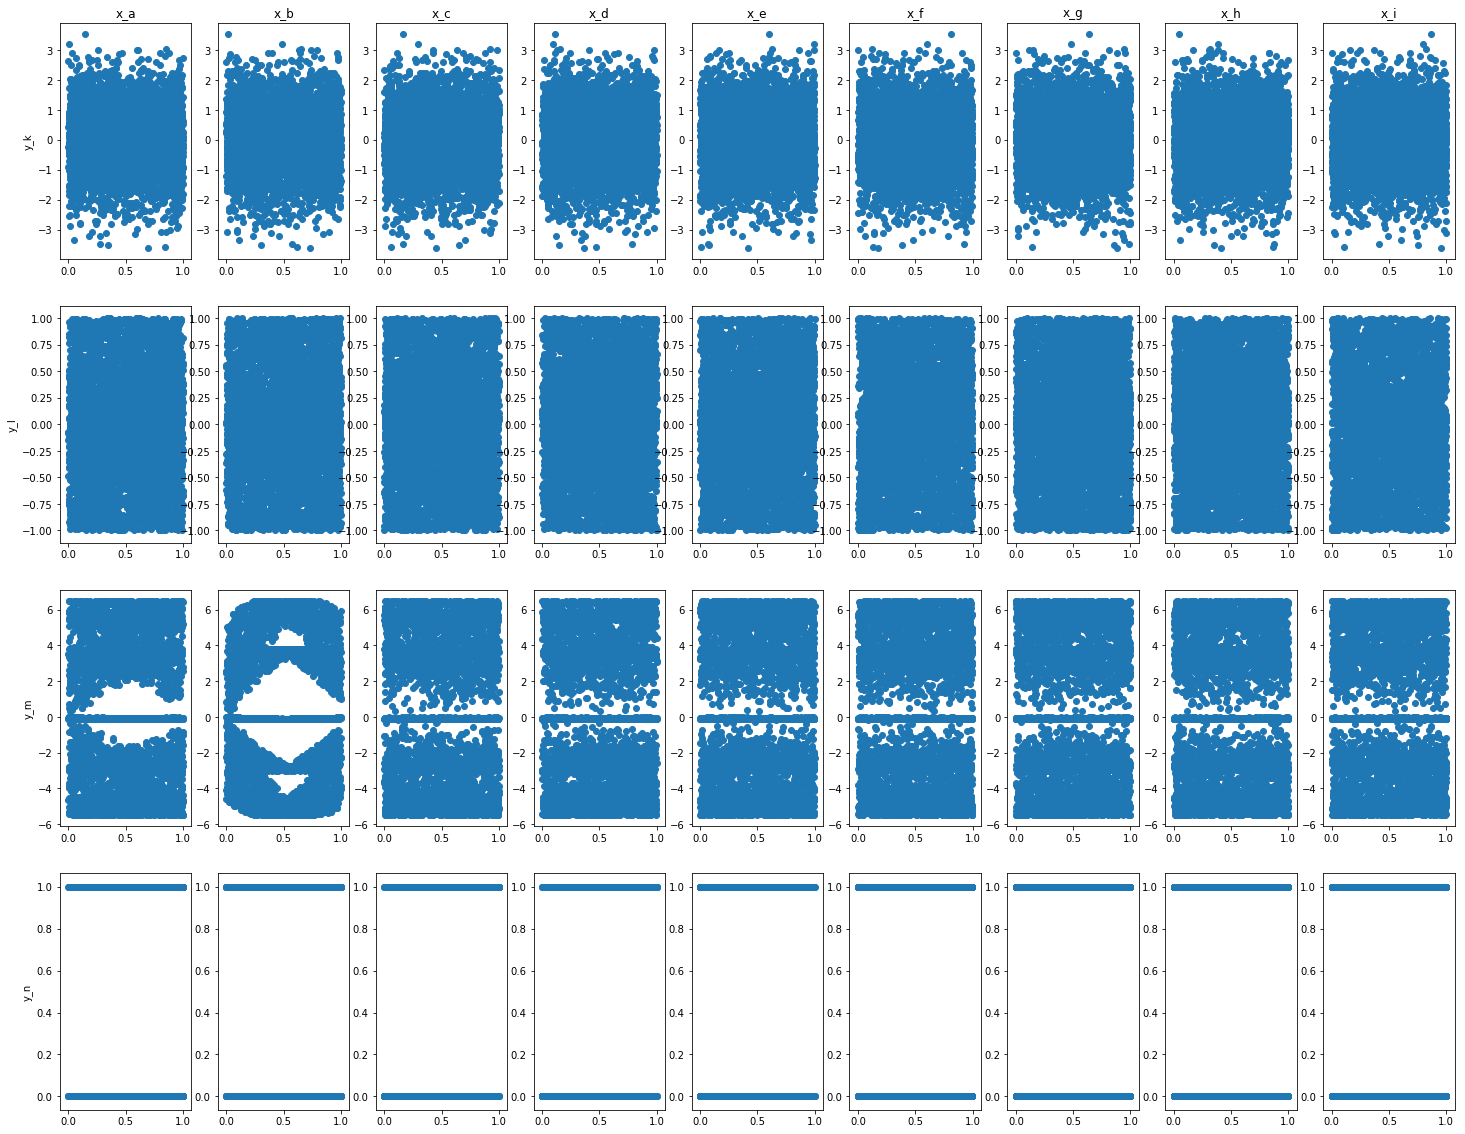

In [110]:
fig, axs = plt.subplots(len(col_y), 9,figsize=(25, 20))

## name rows
for i in range(len(axs)):
    axs[i,0].set_ylabel(col_y[i])
    
## name columns
for i in range(len(col_x)-1):
    axs[0,i].set_title(col_x[i])

## plot data
for i in range(len(axs)):
    fam_val = col_y
    for j in  range(len(col_x)-1):
        axs[i,j].scatter(dt_model[col_x[j]], dt_model[col_y[i]])
        
        
plt.show()

Зависимостей между переменными x и y не наблюдается за исключением переменной y_m с x_a и x_b.

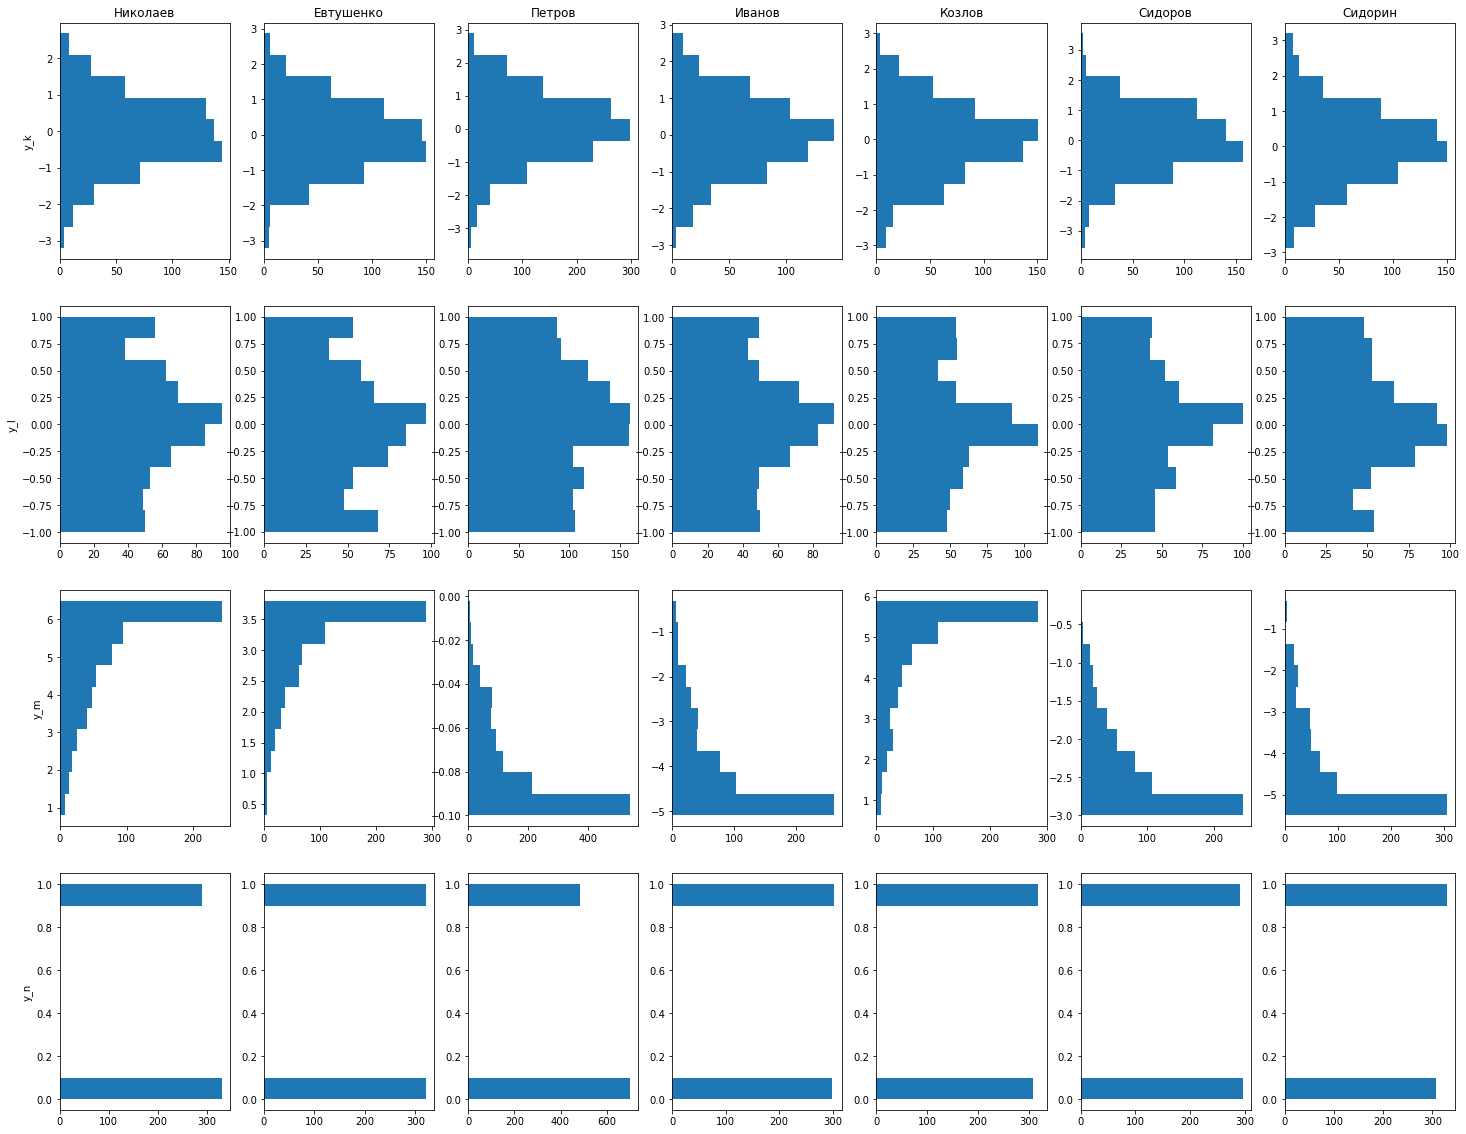

In [115]:
fam_arr = dt_model['x_j'].unique()
fig, axs = plt.subplots(len(col_y),len(fam_arr),figsize=(25, 20))

## name rows
for i in range(len(axs)):
    axs[i,0].set_ylabel(col_y[i])
    
## name columns
for i in range(len(fam_arr)):
    axs[0,i].set_title(fam_arr[i])

## plot data
for i in range(len(axs)):
    fam_val = col_y
    for j in  range(len(fam_arr)):
        fam_val = fam_arr[j]
        dt_plot = dt_model.query('x_j=="'+fam_val+'"').copy(deep=True)
        axs[i,j].hist(dt_plot[col_y[i]], orientation="horizontal")
        pass
        
plt.show()

Наблюдается явная зависимость между переменной y и разными фамилиями из колонки x_j. Для всех остальных "y" практически никаких явных отличий в распределении переменной "x_j" не видно

#### Data Preprocessing

In [189]:
## one hot encoding
dt_model['x_nikolaev'] = 0 +  (dt_model['x_j'] == 'Николаев')
dt_model['x_evtushenko'] = 0 +  (dt_model['x_j'] == 'Евтушенко')
dt_model['x_petrov'] = 0 +  (dt_model['x_j'] == 'Петров')
dt_model['x_ivanov'] = 0 +  (dt_model['x_j'] == 'Иванов')
dt_model['x_kozlov'] = 0 +  (dt_model['x_j'] == 'Козлов')
dt_model['x_sidorov'] = 0 +  (dt_model['x_j'] == 'Сидоров')
dt_model['x_sidorin'] = 0 +  (dt_model['x_j'] == 'Сидорин')

x_names = col_x + ['x_nikolaev','x_evtushenko','x_petrov','x_ivanov','x_kozlov','x_sidorov','x_sidorin']
x_names = [x for x in x_names if x!='x_j']

y_names = ['y_k','y_l','y_m','y_n']

In [170]:
train, valid =  train_test_split(dt_model, test_size = 0.2,random_state = 13)
kf = KFold(n_splits = 5, shuffle = True, random_state = 16)



#### Modeling

##### Regression

_Linear regression_

In [278]:
## r2_score, mean_squared_error

for y_var in  y_names:
    print (y_var)
    clf = LinearRegression()
    scores = cross_val_score(clf, X = train[x_names], y = train[y_var], cv = kf, scoring=make_scorer(r2_score))
    clf.fit(train[x_names], train[y_var])
    predicted = clf.predict(valid[x_names])
    print (scores)
    print ('valid score:', r2_score(valid[y_var],predicted))

y_k
[-0.01279302 -0.00631674 -0.00384118 -0.01480107 -0.00356357]
valid score: 0.002793484388
y_l
[-0.01093879  0.00045727 -0.00308596 -0.00140237  0.00080511]
valid score: -0.00281595146738
y_m
[ 0.93287531  0.93221371  0.94290201  0.94342051  0.93845333]
valid score: 0.932785122416
y_n
[ 0.29926967  0.25117417  0.26268904  0.25202808  0.28280854]
valid score: 0.251791299938


Decision Tree Regressor

In [277]:
for y_var in  y_names:
    print (y_var)
    clf = DecisionTreeRegressor()
    scores = cross_val_score(clf, X = train[x_names], y = train[y_var], cv = kf, scoring=make_scorer(r2_score))
    clf.fit(train[x_names], train[y_var])
    predicted = clf.predict(valid[x_names])
    print (scores)
    print ('valid score:', r2_score(valid[y_var],predicted))

y_k
[-1.16042156 -1.07404143 -1.01493957 -1.25320164 -1.38428895]
valid score: -1.13053945779
y_l
[-1.13040509 -0.91504036 -0.93449572 -0.90321606 -1.03444414]
valid score: -1.03758006083
y_m
[ 0.99550334  0.99355147  0.99489567  0.99467532  0.99509385]
valid score: 0.996343940041
y_n
[ 0.54137883  0.50786936  0.54506275  0.61039657  0.40287081]
valid score: 0.518335249329


In [298]:
for y_var in  y_names:
    print (y_var)
    clf = RandomForestRegressor(n_estimators=100, random_state=19)
    scores = cross_val_score(clf, X = train[x_names], y = train[y_var], cv = kf, scoring=make_scorer(r2_score),n_jobs=-1)
    clf.fit(train[x_names], train[y_var])
    predicted = clf.predict(valid[x_names])
    print (scores)
    print ('valid score:', r2_score(valid[y_var],predicted))

y_k
[-0.05158301 -0.01783541 -0.02175389 -0.03817915 -0.03417916]
valid score: -0.0338063202653
y_l
[-0.02494033  0.00213642 -0.02185997  0.00297501  0.01287273]
valid score: 0.0172143518669
y_m
[ 0.99797212  0.99792374  0.9979677   0.99746316  0.99803699]
valid score: 0.998523001044
y_n
[ 0.80076827  0.7412659   0.74957034  0.7518421   0.75360612]
valid score: 0.795675363623


Мы видим, что зависимые переменные не объясняют переменные y_k и y_l, практически полностью объясняют y_m и частично влияют на y_n

##### binary

In [313]:
##  accuracy_score, roc_auc_score 

y_var = 'y_n'
print (y_var)
clf = LogisticRegression(penalty = 'l1', C=0.1)
scores = cross_val_score(clf, X = train[x_names], y = train[y_var], cv = kf, scoring=make_scorer(accuracy_score))
print (scores)
print (np.mean(scores),np.std(scores))

clf.fit(train[x_names], train[y_var])
predicted = clf.predict(valid[x_names])
print ('valid score:', accuracy_score(valid[y_var],predicted))

y_n
[ 0.76147959  0.74489796  0.75892857  0.74234694  0.7372449 ]
0.748979591837 0.00952456872581
valid score: 0.730612244898


In [314]:
y_var = 'y_n'
print (y_var)
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X = train[x_names], y = train[y_var], cv = kf, scoring=make_scorer(accuracy_score))
print (scores)
print (np.mean(scores),np.std(scores))

clf.fit(train[x_names], train[y_var])
predicted = clf.predict(valid[x_names])
print ('valid score:', accuracy_score(valid[y_var],predicted))

y_n
[ 0.89668367  0.87372449  0.87755102  0.90306122  0.85204082]
0.880612244898 0.0180852774232
valid score: 0.872448979592


In [320]:
y_var = 'y_n'
print (y_var)
clf = RandomForestClassifier(n_estimators=400,random_state=18)
scores = cross_val_score(clf, X = train[x_names], y = train[y_var], cv = kf, scoring=make_scorer(accuracy_score))
print (scores)
print (np.mean(scores),np.std(scores))
                              
clf.fit(train[x_names], train[y_var])
predicted = clf.predict(valid[x_names])
print ('valid score:', accuracy_score(valid[y_var],predicted))

y_n
[ 0.94005102  0.91326531  0.92219388  0.91454082  0.93877551]
0.925765306122 0.0115614991772
valid score: 0.929591836735


In [308]:
RandomForestClassifier??

#### Predicting for test data

In [333]:
dt_model_test = pd.read_excel("data_test.xlsx",sheetname='Test',header=None)
col_x = ['x_a','x_b','x_c','x_d','x_e','x_f','x_g','x_h','x_i','x_j']
dt_model_test.columns = col_x

dt_model_test['x_nikolaev'] = 0 +  (dt_model_test['x_j'] == 'Николаев')
dt_model_test['x_evtushenko'] = 0 +  (dt_model_test['x_j'] == 'Евтушенко')
dt_model_test['x_petrov'] = 0 +  (dt_model_test['x_j'] == 'Петров')
dt_model_test['x_ivanov'] = 0 +  (dt_model_test['x_j'] == 'Иванов')
dt_model_test['x_kozlov'] = 0 +  (dt_model_test['x_j'] == 'Козлов')
dt_model_test['x_sidorov'] = 0 +  (dt_model_test['x_j'] == 'Сидоров')
dt_model_test['x_sidorin'] = 0 +  (dt_model_test['x_j'] == 'Сидорин')

dt_model_test.head()

,x_a,x_b,x_c,x_d,x_e,x_f,x_g,x_h,x_i,x_j,x_nikolaev,x_evtushenko,x_petrov,x_ivanov,x_kozlov,x_sidorov,x_sidorin
0,0.449241,0.490114,0.978225,0.351982,0.689525,0.215533,0.041244,0.520350,0.061213,Сидоров,0,0,0,0,0,1,0
1,0.830178,0.724634,0.613338,0.712169,0.558881,0.843561,0.294518,0.706665,0.797669,Сидоров,0,0,0,0,0,1,0
2,0.905264,0.195994,0.257580,0.136874,0.508315,0.395616,0.352239,0.728190,0.631291,Сидорин,0,0,0,0,0,0,1
3,0.294656,0.401026,0.071320,0.872048,0.439250,0.756922,0.859372,0.599099,0.230198,Козлов,0,0,0,0,1,0,0
4,0.168255,0.129808,0.152529,0.264114,0.200387,0.891744,0.033535,0.148411,0.203505,Козлов,0,0,0,0,1,0,0


In [334]:
for y_var in  y_names:
    print (y_var)
    clf = RandomForestRegressor(n_estimators=100, random_state=19)
    scores = cross_val_score(clf, X = train[x_names], y = train[y_var], cv = kf, scoring=make_scorer(r2_score),n_jobs=-1)
    print (scores)
    print (np.mean(scores),np.std(scores))
    clf.fit(train[x_names], train[y_var])
    predicted = clf.predict(dt_model_test[x_names])
    dt_model_test[y_var] = predicted
    

y_k
[-0.03715095 -0.01292195 -0.01279992 -0.03024429 -0.02632935]
-0.0238892893383 0.00964850449432
y_l
[-0.02821719  0.00349826  0.00473822  0.01271403 -0.01802925]
-0.00505918576706 0.0154247993236
y_m
[ 0.99794905  0.99774114  0.99801929  0.99730339  0.99821156]
0.997844887644 0.000309742640111
y_n
[ 0.80755328  0.74364248  0.75297317  0.7544709   0.76261869]
0.764251703923 0.0224735539524


In [335]:
y_var = 'y_n'
print (y_var)
clf = RandomForestClassifier(n_estimators=400,random_state=18)
scores = cross_val_score(clf, X = train[x_names], y = train[y_var], cv = kf, scoring=make_scorer(accuracy_score))
print (scores)
print (np.mean(scores),np.std(scores))
                              
clf.fit(train[x_names], train[y_var])
predicted = clf.predict(dt_model_test[x_names])
dt_model_test[y_var] = predicted

y_n
[ 0.94005102  0.91326531  0.92219388  0.91454082  0.93877551]
0.925765306122 0.0115614991772


In [336]:
dt_model_test.head()

,x_a,x_b,x_c,x_d,x_e,x_f,x_g,x_h,x_i,x_j,...,x_evtushenko,x_petrov,x_ivanov,x_kozlov,x_sidorov,x_sidorin,y_k,y_l,y_m,y_n
0,0.449241,0.490114,0.978225,0.351982,0.689525,0.215533,0.041244,0.520350,0.061213,Сидоров,...,0,0,0,0,1,0,0.166517,0.129521,-2.845489,1.0
1,0.830178,0.724634,0.613338,0.712169,0.558881,0.843561,0.294518,0.706665,0.797669,Сидоров,...,0,0,0,0,1,0,0.073191,-0.049244,-2.346869,1.0
2,0.905264,0.195994,0.257580,0.136874,0.508315,0.395616,0.352239,0.728190,0.631291,Сидорин,...,0,0,0,0,0,1,0.110218,-0.147505,-5.260886,1.0
3,0.294656,0.401026,0.071320,0.872048,0.439250,0.756922,0.859372,0.599099,0.230198,Козлов,...,0,0,0,1,0,0,-0.136694,0.056377,5.338843,0.0
4,0.168255,0.129808,0.152529,0.264114,0.200387,0.891744,0.033535,0.148411,0.203505,Козлов,...,0,0,0,1,0,0,0.050455,0.006886,2.415646,0.0


In [337]:
 dt_model_test.to_excel("results/result.xlsx")